In [29]:
print('..running')
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
#from pytorch_model_summary import summary
import yaml
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from util import samples_generated, samples_real, plot_curve
import idf
from train import evaluation, training 
from data import load_data
from neural_networks import nnetts

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_dir = 'results/exp_test'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'idf-4'

D = 784   # input dimension
M = D  # the number of neurons in scale (s) and translation (t) nets
lr = 1e-4 # learning rate
num_epochs = 500
max_patience = 5 # Early Stopping
num_flows = 4 # The number of invertible transformations
lam = 0. # Regularization Hyperparameter
n_mixtures = 3 # Number of latent mixing variables
batch_size = 500
hyperparameters = {'D': D, 
                   'M': M,
                   'lr': lr,
                   'num_epochs': num_epochs,
                   'max_patience': max_patience,
                   'num_flows': num_flows,
                   'batch_size': batch_size,
                   'lambda': lam,
                   'n_mixtures': n_mixtures
                    }
with open(result_dir + '/hyperparameters.yaml', 'w') as file:
    yaml.dump(hyperparameters, file)

train_data, val_data, test_data = load_data('mnist')
# Create data loaders
training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

netts = nnetts(D, M)
model = idf.IDF4(netts, num_flows, n_mixtures = n_mixtures, D=D).to(device)
#print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# Training procedure
nll_val = training(name=name, result_dir = result_dir, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                   scheduler=scheduler, training_loader=training_loader, val_loader=val_loader, device=device, lam=lam)

with open(result_dir + '/val_loss.txt', "w") as file:
    for item in nll_val:
        file.write(f"{item}\n")

test_loss = evaluation(name=result_dir + '/' + name, test_loader=test_loader)
f = open(result_dir + '/test_loss.txt', "w")
f.write(str(test_loss))
f.close()

#samples_generated(result_dir + '/' + name, test_loader, 28)
plot_curve(result_dir + '/' + name, nll_val)

..running
Epoch: 0, train nll=1868.475830078125, val nll=1868.2834375
saved!
Epoch: 1, train nll=1859.985595703125, val nll=1859.9153229166666
saved!
Epoch: 2, train nll=1851.6258544921875, val nll=1851.7201770833333
saved!
Epoch: 3, train nll=1843.6077880859375, val nll=1843.4612291666667
saved!
Epoch: 4, train nll=1835.595458984375, val nll=1835.5020520833334
saved!
Epoch: 5, train nll=1827.864501953125, val nll=1827.7071354166667
saved!
Epoch: 6, train nll=1819.6195068359375, val nll=1819.5307291666666
saved!
Epoch: 7, train nll=1811.6295166015625, val nll=1811.6856458333334
saved!
Epoch: 8, train nll=1803.58349609375, val nll=1803.714
saved!
Epoch: 9, train nll=1795.235595703125, val nll=1795.244625
saved!
Epoch: 10, train nll=1787.1182861328125, val nll=1786.9579583333334
saved!
Epoch: 11, train nll=1779.1593017578125, val nll=1778.9910625
saved!
Epoch: 12, train nll=1770.8480224609375, val nll=1770.78509375
saved!
Epoch: 13, train nll=1762.708740234375, val nll=1762.7255729166666

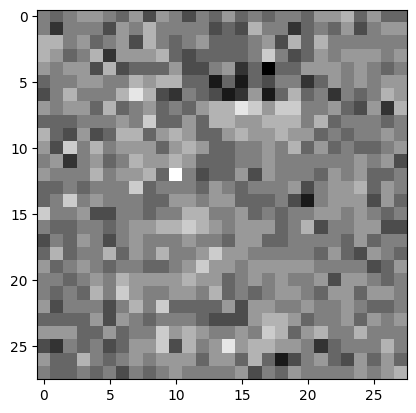

In [30]:
import numpy as np
import matplotlib.pyplot as plt
x = next(iter(val_loader)).detach().numpy()

# GENERATIONS-------
model_best = torch.load(result_dir + '/' + name + '.model')
model_best.eval()

x = model_best.sample(num_x * num_y)
x = x.detach().numpy()

fig, ax = plt.subplots(num_x, num_y)
plottable_image = np.reshape(x, (28, 28))
ax.imshow(plottable_image, cmap='gray')
#ax.axis('off')

#plt.savefig(result_dir + '/' + name + '_generated_images' + '.pdf', bbox_inches='tight')
#plt.close()